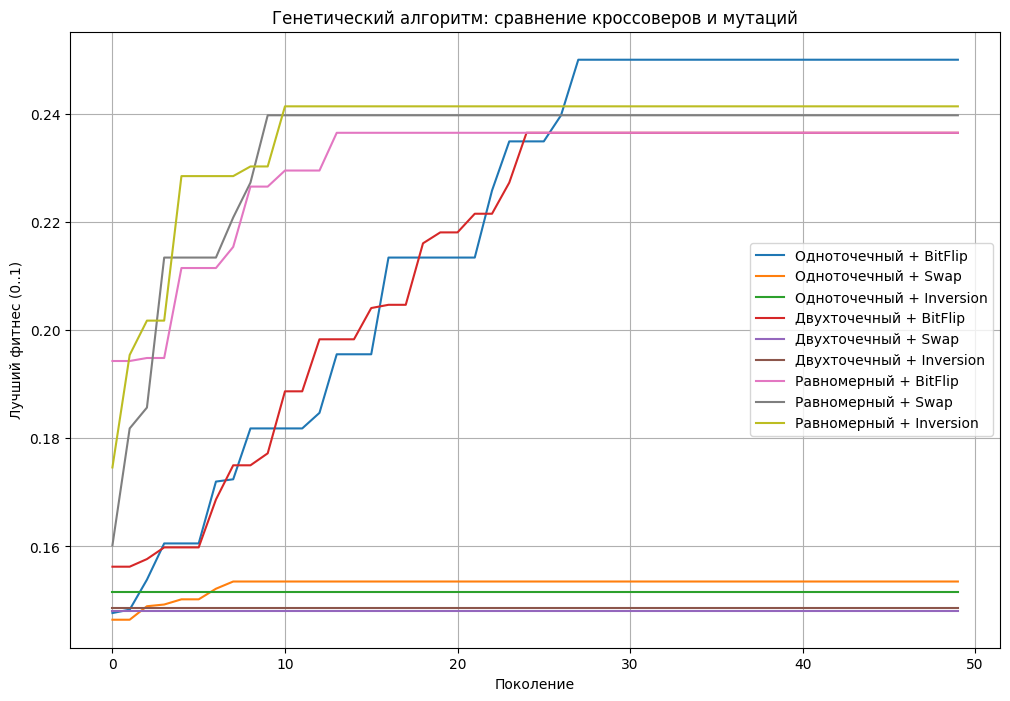

=== Лучшее найденное решение (Генетический алгоритм) ===
Методы скрещивания и мутации: Одноточечный + BitFlip
Матрица распределения (заводы × города):
[[23  0]
 [17 12]
 [ 0 18]]
Фитнес: 0.2500
Транспортные расходы: 0.28 тыс.
Фактически доставлено в города: [40, 30]
Спрос городов: [40, 30]

=== Оптимальное решение (Полный перебор) ===
Матрица распределения (заводы × города):
[[30  0]
 [10 30]
 [ 0 20]]
Фитнес: 0.1552
Транспортные расходы: 0.35 тыс.
Фактически доставлено в города: [40, 50]
Спрос городов: [40, 30]


In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ==============================
# Параметры задачи
# ==============================
N = 3   # Количество заводов
K = 2   # Количество городов

factories = [30, 40, 20]       # Ёмкость заводов
cities_demand = [40, 30]       # Спрос городов

transport_costs = np.array([ #Cколько продукции завода i отправляется в город j 
    [4, 6],
    [5, 4],
    [8, 3]
])

# ==============================
# Настройки генетического алгоритма
# ==============================
population_size = 50
generations = 50
mutation_rate = 0.2

# ==============================
# Функция фитнеса
# ==============================
def fitness(solution):
    supplies_to_cities = np.sum(solution, axis=0)
    total_cost = np.sum(solution * transport_costs)
    satisfied = np.minimum(supplies_to_cities, cities_demand)

    penalties = 0
    for i in range(N):
        if np.sum(solution[i]) > factories[i]:
            penalties += (np.sum(solution[i]) - factories[i]) * 10
    for j in range(K):
        if supplies_to_cities[j] < cities_demand[j]:
            penalties += (cities_demand[j] - supplies_to_cities[j]) * 20
        if supplies_to_cities[j] > cities_demand[j]:
            penalties += (supplies_to_cities[j] - cities_demand[j]) * 5  # штраф за превышение

    score = sum(satisfied) / (total_cost + penalties + 1)
    return score, total_cost, supplies_to_cities

# ==============================
# Генерация начальной популяции
# ==============================
def initialize_population():
    population = []
    for _ in range(population_size):
        individual = np.zeros((N, K), dtype=int)
        for i in range(N):
            remaining = factories[i]
            for j in range(K - 1):
                val = random.randint(0, remaining)
                individual[i][j] = val
                remaining -= val
            individual[i][K - 1] = remaining
        population.append(individual)
    return population

# ==============================
# Селекция
# ==============================
def selection(population):
    scores = [fitness(ind)[0] for ind in population]
    selected_indices = np.argsort(scores)[-population_size // 2:]
    return [population[i] for i in selected_indices]

# ==============================
# Кроссоверы
# ==============================
def single_point_crossover(p1, p2): #случ строка и меняем части родителей 
    point = random.randint(1, N - 1)
    c1 = np.vstack((p1[:point], p2[point:]))
    c2 = np.vstack((p2[:point], p1[point:]))
    return c1, c2

def two_point_crossover(p1, p2): #берем 2 точки и между ними меняем строки
    points = sorted(random.sample(range(1, N), 2))
    c1, c2 = p1.copy(), p2.copy()
    c1[points[0]:points[1]] = p2[points[0]:points[1]]
    c2[points[0]:points[1]] = p1[points[0]:points[1]]
    return c1, c2

def uniform_crossover(p1, p2): #для кажд эл случайно решаем от какого родителя его взять 
    mask = np.random.rand(N, K) > 0.5
    c1 = np.where(mask, p1, p2)
    c2 = np.where(mask, p2, p1)
    return c1, c2

# ==============================
# Мутации
# ==============================
def bit_flip_mutation(ind): #немного увел или уменьш случ элем матрицы 
    i, j = random.randint(0, N - 1), random.randint(0, K - 1)
    ind[i][j] = max(0, ind[i][j] + random.randint(-3, 3))
    return ind

def swap_mutation(ind): #меняем кол-во продукции между двумя городами
    i = random.randint(0, N - 1)
    j1, j2 = random.sample(range(K), 2)
    ind[i][j1], ind[i][j2] = ind[i][j2], ind[i][j1]
    return ind

def inversion_mutation(ind): #берем часть строки и переворачиваем
    i = random.randint(0, N - 1)
    start, end = sorted(random.sample(range(K), 2))
    ind[i][start:end] = ind[i][start:end][::-1]
    return ind

# ==============================
# Генетический алгоритм
# ==============================
def genetic_algorithm(crossover_method, mutation_method):
    population = initialize_population()
    best_fitness_history = []

    for _ in range(generations):
        selected = selection(population)
        next_population = selected.copy()

        while len(next_population) < population_size:
            parent1, parent2 = random.sample(selected, 2)
            child1, child2 = crossover_method(parent1, parent2)
            if random.random() < mutation_rate:
                child1 = mutation_method(child1)
            if random.random() < mutation_rate:
                child2 = mutation_method(child2)
            next_population.extend([child1, child2])

        population = next_population[:population_size]
        best_solution = max(population, key=lambda ind: fitness(ind)[0])
        best_fitness_history.append(fitness(best_solution)[0])

    return best_fitness_history, best_solution

# ==============================
# Ускоренный генератор распределений
# ==============================
def generate_allocations(capacity, K):
    if K == 1:
        yield (capacity,)
    else:
        for i in range(capacity + 1):
            for rest in generate_allocations(capacity - i, K - 1):
                yield (i,) + rest

# ==============================
# Полный перебор с минимальным превышением
# ==============================
def brute_force():
    best_solution = None
    best_score = -1
    min_overdeliver = float('inf')

    for alloc1 in generate_allocations(factories[0], K):
        for alloc2 in generate_allocations(factories[1], K):
            for alloc3 in generate_allocations(factories[2], K):
                solution = np.array([alloc1, alloc2, alloc3])
                _, _, demand = fitness(solution)
                overdeliver = sum(max(0, demand[j]-cities_demand[j]) for j in range(K))
                # Выбираем вариант с минимальным превышением
                if overdeliver > min_overdeliver:
                    continue
                score, cost, _ = fitness(solution)
                if overdeliver < min_overdeliver or score > best_score:
                    best_score = score
                    best_solution = solution
                    min_overdeliver = overdeliver

    return best_solution, best_score

# ==============================
# Основной код
# ==============================
crossover_methods = {
    "Одноточечный": single_point_crossover,
    "Двухточечный": two_point_crossover,
    "Равномерный": uniform_crossover,
}

mutation_methods = {
    "BitFlip": bit_flip_mutation,
    "Swap": swap_mutation,
    "Inversion": inversion_mutation,
}

plt.figure(figsize=(12, 8))
best_global = None
best_score = -1
best_methods = None

for cross_name, cross_func in crossover_methods.items():
    for mut_name, mut_func in mutation_methods.items():
        scores, solution = genetic_algorithm(cross_func, mut_func)
        plt.plot(scores, label=f"{cross_name} + {mut_name}")
        score, cost, demand = fitness(solution)
        if score > best_score:
            best_score = score
            best_global = solution
            best_methods = (cross_name, mut_name)

plt.title("Генетический алгоритм: сравнение кроссоверов и мутаций")
plt.xlabel("Поколение")
plt.ylabel("Лучший фитнес (0..1)")
plt.legend()
plt.grid()
plt.show()

# ==============================
# Вывод GA
# ==============================
score, cost, demand = fitness(best_global)
print("=== Лучшее найденное решение (Генетический алгоритм) ===")
print(f"Методы скрещивания и мутации: {best_methods[0]} + {best_methods[1]}")
print("Матрица распределения (заводы × города):")
print(best_global)
print(f"Фитнес: {score:.4f}")
print(f"Транспортные расходы: {cost/1000:.2f} тыс.")
print("Фактически доставлено в города:", demand.tolist())
print("Спрос городов:", cities_demand)

# ==============================
# Вывод brute force
# ==============================
bf_solution, bf_score = brute_force()
if bf_solution is not None:
    bf_cost = np.sum(bf_solution * transport_costs)
    bf_demand = np.sum(bf_solution, axis=0)

    print("\n=== Оптимальное решение (Полный перебор) ===")
    print("Матрица распределения (заводы × города):")
    print(bf_solution)
    print(f"Фитнес: {bf_score:.4f}")
    print(f"Транспортные расходы: {bf_cost/1000:.2f} тыс.")
    print("Фактически доставлено в города:", bf_demand.tolist())
    print("Спрос городов:", cities_demand)
else:
    print("\n=== Полный перебор не нашёл допустимого решения ===")